In [1]:
pip install census

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


# Geospatial Transfer Learning with Merged Yelp and ACS Data for Ecomonic Development Simulation and Planning 

### Project rationale 

Current tools provide a county level view geospatial view of food insecurity. ACS data is avaliable for public download at the census tract and block level. The ACS data is rich in various Concepts each with many survey items related to demographics,  health, SDOH, proverty , living , housing and economic condition. However, this level of detail while helpful might be overwhelming from an visual analysis. Local and regional efforts have aggregated and ranked food deserts at the zip code level. 

Therefore , while overall county level performance is readily avaliable a planning system to improve the avaliability and access to nutritous food at the census tract, census block that is aggregated at the zip code level can help to plan and assess proximal , medial and distable outcomes of interventions that can imporve food security. 

The interventions could be proximal such as those focused on immediate food distribution during an acute event, medial in terms of imporvement of the built enviroment such as setting up of grocery stores that are in walking distance so as to give local resident access to nutritous food or distal such as changing policy to encourage the local community to provide services to visitor and toursits thereby facilitating a more equitiable distribution of visitor dollars. 

### Project Sections 

This project is done in three sections 

1. Exploratory Data Analysis of Geo Spatial Data including selection , pre processing and visualization. 
    We have three Geo Spatial Data sets that we utilize in this project
    (A) Amercian Community Survey data with geometries at the county , tract, block level. 
    (B) Food Desert Ranking based on zip code and census tract https://www.healthyneo.org/indexsuite/index/foodinsecurity?localeType=4 
    (C) Food and Restaurant related business in target city ( cleveland ) and comparison city ( toronoto ) 
    (D) Mapping Ratings of review in target city at the zip code level and the census tract level
    

2. Yelp data selection , pre-processing and combing yelp data business attributes with ACS features and location based ranking from the food security index rank. 
    (A) Exploring type of features and selecting one hot encoding business types to select business types of interest
    (B) Exploring features of the combined data sets for utility in review prediction 
    (C) Creating zip code and census tract based subsets of business in target city and comparison city 
    (D) Pre-Process data for restaurant review prediction without ACS features and FD Ranking based on zip and census tract. 
    (F) Generate target city maps with seperate layers for business location, zip code level polygon with FD ranking , census tract level polygon for FD ranking , ZTACS level ACS attributes and census tract level ACS attributes. 
    (E) Perfrom spatial joins to add ACS and attributes to business based on business census tract location. 
    (F) Perform spatial joins to add Ranking data and FD index score to business based on Zip code and census tracts. 
    
    
    
    

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, datasets, read_file
from census import Census
#from us import states 
import numpy as np 
import folium
from folium import Choropleth , Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import shapely.wkt
from shapely.geometry import Polygon
from shapely.geometry import Point
import random
import seaborn as sns

This is the section to perform spatial joins
1. Get ACS data for food deserts at the census tract level https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/
2. Get the Zip code level ran

In [6]:
def polygons_from_custom_xy_string(df_column):
    
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    
    def xy_list_from_string(s):
        # 'x y x y ...' -> [[x, y], [x, y], ...]
        return list(chunks([float(i) for i in s.split()], 2))
    
    def poly(s):
        """ returns shapely polygon from point list"""
        ps = xy_list_from_string(s)
        return Polygon([[p[0], p[1]] for p in ps])

    polygons = [poly(r) for r in df_column]

    return polygons

In [7]:
# c = Census("32969f3dc3522389611b1a25754e4cde9b00886c")

In [63]:
ch_ct_acs_FD = pd.read_csv('cuyahoga_census_tract_FD_var.csv')

C:\Users\chait\AppData\Local\Temp\ipykernel_7820\335890056.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  ch_ct_acs_FD = pd.read_csv('cuyahoga_census_tract_FD_var.csv')


In [64]:
ch_zip_rank_FD = pd.read_csv('CH_ZIP_FD_RATING.csv')

In [65]:
ch_ct_rank_FD = pd.read_csv('ch_ct_rank_FD.csv')

In [66]:
ch_ct_rank_FD

Census Tract  Index  Rank    County
0     39035109701  100.0     5  Cuyahoga
1     39035109801  100.0     5  Cuyahoga
2     39035114300  100.0     5  Cuyahoga
3     39035108701   99.9     5  Cuyahoga
4     39093070901   99.9     5    Lorain
..            ...    ...   ...       ...
831   39153534100    1.8     1    Summit
832   39035183300    1.2     1  Cuyahoga
833   39035179102    1.0     1  Cuyahoga
834   39035194500    0.9     1  Cuyahoga
835   39035179101    0.3     1  Cuyahoga

[836 rows x 4 columns]

In [67]:
ch_zip_rank_FD

Site Region Unnamed: 1 Unnamed: 2 Unnamed: 3              Unnamed: 4
0      Zip Code      Index       Rank     County         Substate Region
1         44104       99.8          5   Cuyahoga  Healthy Northeast Ohio
2         44307       99.6          5     Summit  Healthy Northeast Ohio
3         44115       99.4          5   Cuyahoga  Healthy Northeast Ohio
4         44127       99.2          5   Cuyahoga  Healthy Northeast Ohio
..          ...        ...        ...        ...                     ...
156       44141          3          1   Cuyahoga  Healthy Northeast Ohio
157       44233        2.6          1     Medina  Healthy Northeast Ohio
158       44236        2.2          1     Summit  Healthy Northeast Ohio
159       44022          2          1   Cuyahoga  Healthy Northeast Ohio
160       44040        0.4          1   Cuyahoga  Healthy Northeast Ohio

[161 rows x 5 columns]

In [68]:
ch_ct_acs_FD = ch_ct_acs_FD.iloc[: 50931]

In [69]:
ch_ct_acs_FD.select_dtypes(include = np.number).columns.tolist()

['CensusTract',
 'Urban',
 'Pop2010',
 'OHU2010',
 'GroupQuartersFlag',
 'NUMGQTRS',
 'PCTGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'HUNVFlag',
 'LowIncomeTracts',
 'PovertyRate',
 'MedianFamilyIncome',
 'LA1and10',
 'LAhalfand10',
 'LA1and20',
 'LATracts_half',
 'LATracts1',
 'LATracts10',
 'LATracts20',
 'LATractsVehicle_20',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lapophalfshare',
 'lalowihalf',
 'lalowihalfshare',
 'lakidshalf',
 'lakidshalfshare',
 'laseniorshalf',
 'laseniorshalfshare',
 'lawhitehalf',
 'lawhitehalfshare',
 'lablackhalf',
 'lablackhalfshare',
 'laasianhalf',
 'laasianhalfshare',
 'lanhopihalf',
 'lanhopihalfshare',
 'laaianhalf',
 'laaianhalfshare',
 'laomultirhalf',
 'laomultirhalfshare',
 'lahisphalf',
 'lahisphalfshare',
 'lahunvhalf',
 'lahunvhalfshare',
 'lasnaphalf',
 'lasnaphalfshare',
 'lapop1',
 'lapop1share',
 'lalowi1',
 'lalowi1s

In [71]:
ch_ct_acs_FD_cln = ch_ct_acs_FD.drop(ch_ct_acs_FD.loc[:,'lapop1':'lasnap20share'].columns, axis =1)
ch_ct_acs_FD_cln = ch_ct_acs_FD_cln.fillna(0)
ch_ct_acs_FD_cln['CensusTract']

0        3.903510e+10
1        3.903510e+10
2        3.903510e+10
3        3.903510e+10
4        3.903510e+10
             ...     
50926    0.000000e+00
50927    0.000000e+00
50928    0.000000e+00
50929    0.000000e+00
50930    0.000000e+00
Name: CensusTract, Length: 50931, dtype: float64

In [72]:
ch_ct_acs_FD_cln['CensusTract'] = ch_ct_acs_FD_cln['CensusTract'].astype(np.int64)
ch_ct_acs_FD_cln['CensusTract'] = ch_ct_acs_FD_cln['CensusTract'].astype(np.str)

C:\Users\chait\AppData\Local\Temp\ipykernel_7820\982808818.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_ct_acs_FD_cln['CensusTract'] = ch_ct_acs_FD_cln['CensusTract'].astype(np.str)


In [73]:
ch_ct_acs_FD_cln['CensusTract'] = ch_ct_acs_FD_cln['CensusTract'].apply(lambda x: x[5:11])

In [74]:
ch_ct_acs_FD_cln['CensusTract']

0        101101
1        101102
2        101200
3        101300
4        101400
          ...  
50926          
50927          
50928          
50929          
50930          
Name: CensusTract, Length: 50931, dtype: object

In [75]:
ch_ct_acs_FD_cln['CensusTract'] = pd.to_numeric(ch_ct_acs_FD_cln['CensusTract'], errors='coerce').fillna(0).astype(int)

In [76]:
ch_ct_acs_FD_cln['CensusTract'].nunique()

445

In [79]:
ch_ct_acs_FD_cln.head(5)

CensusTract State           County  Urban  Pop2010  OHU2010  \
0       101101  Ohio  Cuyahoga County    1.0   1783.0    850.0   
1       101102  Ohio  Cuyahoga County    1.0   4221.0   2474.0   
2       101200  Ohio  Cuyahoga County    1.0   2562.0   1379.0   
3       101300  Ohio  Cuyahoga County    1.0   1629.0    841.0   
4       101400  Ohio  Cuyahoga County    1.0   2195.0    813.0   

   GroupQuartersFlag  NUMGQTRS  PCTGQTRS  LILATracts_1And10  ...  \
0                0.0     139.0      7.80                0.0  ...   
1                0.0       9.0      0.21                0.0  ...   
2                0.0      56.0      2.19                0.0  ...   
3                0.0     146.0      8.96                0.0  ...   
4                0.0      36.0      1.64                0.0  ...   

   TractSeniors  TractWhite  TractBlack  TractAsian  TractNHOPI  TractAIAN  \
0         199.0       821.0       788.0        35.0         0.0        5.0   
1         412.0      3172.0       677.0        96.0         2.0       16.0   
2         423.0      1522.0       648.0        35.0         0.0        8.0   
3         283.0       948.0       550.0        17.0         1.0       12.0   
4         133.0      1165.0       547.0        64.0         1.0       17.0   

   TractOMultir  TractHispanic  TractHUNV  TractSNAP  
0         134.0          179.0      326.0      470.0  
1         258.0          350.0      566.0      335.0  
2         349.0          596.0      485.0      613.0  
3         101.0          157.0      338.0      295.0  
4         401.0          526.0      237.0      325.0  

[5 rows x 69 columns]

In [81]:
ch_ct_rank_FD['Census Tract'] = ch_ct_rank_FD['Census Tract'].astype(np.str)
ch_ct_rank_FD['Census Tract'] = ch_ct_rank_FD['Census Tract'].apply(lambda x: x[5:11])
ch_ct_rank_FD

C:\Users\chait\AppData\Local\Temp\ipykernel_7820\2808690263.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ch_ct_rank_FD['Census Tract'] = ch_ct_rank_FD['Census Tract'].astype(np.str)


Census Tract  Index  Rank    County
0         109701  100.0     5  Cuyahoga
1         109801  100.0     5  Cuyahoga
2         114300  100.0     5  Cuyahoga
3         108701   99.9     5  Cuyahoga
4         070901   99.9     5    Lorain
..           ...    ...   ...       ...
831       534100    1.8     1    Summit
832       183300    1.2     1  Cuyahoga
833       179102    1.0     1  Cuyahoga
834       194500    0.9     1  Cuyahoga
835       179101    0.3     1  Cuyahoga

[836 rows x 4 columns]

In [82]:
ch_ct_rank_FD['Census Tract'] = pd.to_numeric(ch_ct_rank_FD['Census Tract'], errors='coerce').fillna(0).astype(int)

In [83]:
ch_ct_rank_acs_FD = pd.merge(ch_ct_rank_FD, ch_ct_acs_FD_cln, left_on='Census Tract', right_on='CensusTract')

In [87]:
ch_ct_rank_acs_FD.drop('CensusTract', axis=1, inplace=True)

In [89]:
ch_ct_rank_acs_FD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 440
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Census Tract          441 non-null    int32  
 1   Index                 441 non-null    float64
 2   Rank                  441 non-null    int64  
 3   County_x              441 non-null    object 
 4   State                 441 non-null    object 
 5   Urban                 441 non-null    float64
 6   Pop2010               441 non-null    float64
 7   OHU2010               441 non-null    float64
 8   GroupQuartersFlag     441 non-null    float64
 9   NUMGQTRS              441 non-null    float64
 10  PCTGQTRS              441 non-null    float64
 11  LILATracts_1And10     441 non-null    float64
 12  LILATracts_halfAnd10  441 non-null    float64
 13  LILATracts_1And20     441 non-null    float64
 14  LILATracts_Vehicle    441 non-null    float64
 15  HUNVFlag              4

We now have a combined dataframe with rank and acs features at the census tract level. To this we need to add census tract level geomertries for cuyahoga county. We have previously prepared the geojson file. We now merge these two files to get the census tract level layer that can be mapped. 

In [90]:
cuyahoga_ct = gpd.read_file('cuyahoga.geojson')

In [91]:
cuyahoga_ct.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1161 non-null   object  
 1   COUNTYFP  1161 non-null   object  
 2   TRACTCE   1161 non-null   object  
 3   BLKGRPCE  1161 non-null   object  
 4   AFFGEOID  1161 non-null   object  
 5   GEOID     1161 non-null   object  
 6   NAME      1161 non-null   object  
 7   LSAD      1161 non-null   object  
 8   ALAND     1161 non-null   int32   
 9   AWATER    1161 non-null   int32   
 10  geometry  1161 non-null   geometry
dtypes: geometry(1), int32(2), object(8)
memory usage: 90.8+ KB


In [92]:
#convert TRACTCE into a numeric to merge the geodataframe cuyahoga_ct with the clean ACS data. We do this to add census tract level geometry to the ACS census 
cuyahoga_ct['TRACTCE'] = pd.to_numeric(cuyahoga_ct['TRACTCE'], errors='coerce').fillna(0).astype(int)

In [93]:
df3 = pd.merge(cuyahoga_ct, ch_ct_rank_acs_FD, left_on='TRACTCE', right_on='Census Tract')

In [94]:
df3.info()
# df3 is a geodataframe and the geometry is that of a polygon. 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1156 entries, 0 to 1155
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   STATEFP               1156 non-null   object  
 1   COUNTYFP              1156 non-null   object  
 2   TRACTCE               1156 non-null   int32   
 3   BLKGRPCE              1156 non-null   object  
 4   AFFGEOID              1156 non-null   object  
 5   GEOID                 1156 non-null   object  
 6   NAME                  1156 non-null   object  
 7   LSAD                  1156 non-null   object  
 8   ALAND                 1156 non-null   int32   
 9   AWATER                1156 non-null   int32   
 10  geometry              1156 non-null   geometry
 11  Census Tract          1156 non-null   int32   
 12  Index                 1156 non-null   float64 
 13  Rank                  1156 non-null   int64   
 14  County_x              1156 non-null   object  
 

In [129]:
df3.to_file("ch_ct_rank_acs_geom_fd.geojson", driver='GeoJSON')

In [118]:
df3.explore("Rank", legend=True)

In [96]:
df3['laomultirhalfshare'].nunique()

274

In [45]:
zip_us_gdf = gpd.read_file('tl_2019_us_zcta510/tl_2019_us_zcta510.shp')

In [97]:
zip_us_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZCTA5CE10   33144 non-null  object  
 1   GEOID10     33144 non-null  object  
 2   CLASSFP10   33144 non-null  object  
 3   MTFCC10     33144 non-null  object  
 4   FUNCSTAT10  33144 non-null  object  
 5   ALAND10     33144 non-null  int64   
 6   AWATER10    33144 non-null  int64   
 7   INTPTLAT10  33144 non-null  object  
 8   INTPTLON10  33144 non-null  object  
 9   geometry    33144 non-null  geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 2.5+ MB


In [100]:
ch_zip_FD.drop('Substate Region', axis=1, inplace=True)

C:\Users\chait\AppData\Local\Temp\ipykernel_7820\3707868766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch_zip_FD.drop('Substate Region', axis=1, inplace=True)


In [101]:
ch_zip_FD

0   Zip Code Index Rank    County
1      44104  99.8    5  Cuyahoga
2      44307  99.6    5    Summit
3      44115  99.4    5  Cuyahoga
4      44127  99.2    5  Cuyahoga
5      44110  98.4    5  Cuyahoga
..       ...   ...  ...       ...
156    44141     3    1  Cuyahoga
157    44233   2.6    1    Medina
158    44236   2.2    1    Summit
159    44022     2    1  Cuyahoga
160    44040   0.4    1  Cuyahoga

[160 rows x 4 columns]

In [102]:
df_zip_CH = pd.merge(ch_zip_FD, zip_us_gdf, left_on='Zip Code', right_on='ZCTA5CE10')

In [103]:
df_zip_CH= df_zip_CH.loc[df_zip_CH['County'] == "Cuyahoga"]

In [115]:
df_zip_CH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 159
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Zip Code    51 non-null     object  
 1   Index       51 non-null     object  
 2   Rank        51 non-null     object  
 3   County      51 non-null     object  
 4   ZCTA5CE10   51 non-null     object  
 5   GEOID10     51 non-null     object  
 6   CLASSFP10   51 non-null     object  
 7   MTFCC10     51 non-null     object  
 8   FUNCSTAT10  51 non-null     object  
 9   ALAND10     51 non-null     int64   
 10  AWATER10    51 non-null     int64   
 11  INTPTLAT10  51 non-null     object  
 12  INTPTLON10  51 non-null     object  
 13  geometry    51 non-null     geometry
dtypes: geometry(1), int64(2), object(11)
memory usage: 6.0+ KB


In [108]:
ch_zip_rank_geom_FD = gpd.GeoDataFrame(df_zip_CH)

In [117]:
ch_zip_rank_geom_FD.explore("Rank", legend=True)

In [110]:
ch_zip_rank_geom_FD.to_file("ch_zip_rank_geom_FD.geojson", driver="GeoJSON")

In [35]:
def random_html_color():
    r = random.randint(0,256)
    g = random.randint(0,256)
    b = random.randint(0,256)
    return '#%02x%02x%02x' % (r, g, b)


In [36]:
def highlight_fcn(x):
    return { 'fillColor': '#ff0000' }

In [33]:
m = folium.Map(location = [41.4993, -81.6944],
               zoom_start = 14)
clevelandzip = folium.Map(location = [41.4993, -81.6944],
               zoom_start = 12)

In [34]:
m

In [114]:
m.choropleth(geo_data = 'ch_zip_rank_FD.geojson',
               data = ch_zip_rank_geom_FD, 
               columns = ['Rank','Zip Code'], 
               key_on= 'feature.properties.ZCTA5CE10', 
               fill_color= 'YlOrBr',
               fill_opacity = 0.6,
               line_opacity=0.2,
               legend_name = 'Rank of Zip')

C:\Users\chait\anaconda3\lib\site-packages\folium\folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Rank']).add_to(geo_j)
    geo_j.add_to(m)
m

In [ ]:
m

In [ ]:
folium.GeoJson(zip_us_gdf).add_to(m)

In [119]:
folium.Marker(
    location = [41.4993, -81.6944],
    popup='Welcome to <b>Cleveland</b>',
    tooltip = "Click for more"
).add_to(m)

In [120]:
business = pd.read_json("business_sample_cleveland.json", lines = True)

In [121]:
geometry = [Point(xy) for xy in zip(business.longitude, business.latitude)]
df = business.drop(['longitude', 'latitude'], axis=1)
gdf_yelp_business = GeoDataFrame(business, crs="EPSG:4326", geometry=geometry)

In [122]:
gdf_yelp_food = gdf_yelp_business[gdf_yelp_business.categories.apply(lambda row: "Food" in row)]

In [123]:
gdf_yelp_food.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 586 entries, 1 to 3158
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   address       586 non-null    object  
 1   attributes    586 non-null    object  
 2   business_id   586 non-null    object  
 3   categories    586 non-null    object  
 4   city          586 non-null    object  
 5   hours         586 non-null    object  
 6   is_open       586 non-null    int64   
 7   latitude      586 non-null    float64 
 8   longitude     586 non-null    float64 
 9   name          586 non-null    object  
 10  neighborhood  586 non-null    object  
 11  postal_code   586 non-null    object  
 12  review_count  586 non-null    int64   
 13  stars         586 non-null    float64 
 14  state         586 non-null    object  
 15  geometry      586 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(10)
memory usage: 77.8+ KB


In [124]:
 gdf_yelp_food['stars'].astype('int')

1       4
8       4
16      4
20      4
21      4
       ..
3121    3
3131    4
3136    2
3157    4
3158    4
Name: stars, Length: 586, dtype: int32

<AxesSubplot:>

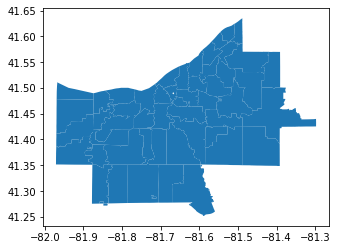

In [125]:
gdf.plot()

In [126]:
for index, row in gdf_yelp_food.iterrows():
.plot()

IndentationError: expected an indented block (3662534882.py, line 2)

In [127]:
color_pallete = sns.color_palette()
color_pallete = sns.color_palette("Set2", 8000)
color_pallete = color_pallete.as_hex()

for index, row in gdf_yelp_food.iterrows():
    c = color_pallete[7]
    folium.CircleMarker([row['latitude'], row['longitude']], fill_color=c, radius=2, fill=True, color=c).add_to(m)

In [128]:
m